## Preprocessing data for Mask RCNN

In [1]:
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
import os
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings
warnings.filterwarnings("ignore")

In [3]:
DATA_DIR = "E:/Kaggle/VinBigData/"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")
SS_CSV_DIR = os.path.join(DATA_DIR, "sample_submission.csv")

PREPROCESSING_FOLDER = 'C:/Users/windows/Desktop/Research/3. Code/0_github_code/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/training_data/'

In [4]:
train_df = pd.read_csv(TRAIN_CSV_DIR)

In [5]:
len(train_df)

67914

### Helper functions for converting bounding boxes to the right format for Mask RCNN

In [6]:
def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
    img_mask[y_min:y_max,x_min:x_max] = 255
    return img_mask.astype(np.float32)
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

### Function convert DICOM data to np.array


In [7]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data


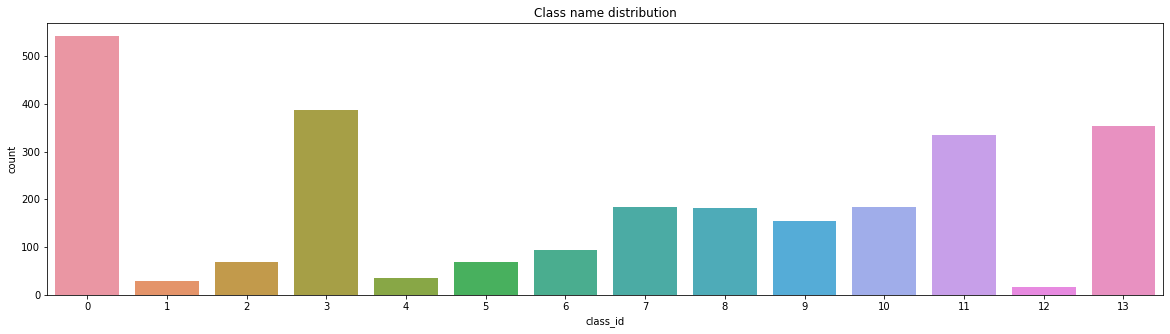

In [8]:
# sample dataset
NUM_OF_SAMPLE = 5000
bbox_df_abnormality = train_df[train_df['class_id'] != 14]

train_df_sample = bbox_df_abnormality.loc[:NUM_OF_SAMPLE]
# sample dataset class distribution
plt.figure(figsize=(20,5))
sns.countplot(x = 'class_id', data = train_df_sample)
plt.title('Class name distribution')
plt.show()

In [9]:
train_df_sample

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
4992,3c63e58fcda26e02fdd6619515399985,Lung Opacity,7,R9,453.0,506.0,923.0,1283.0
4993,44227b3ea199ef4a06524f5c843e2608,Pleural thickening,11,R8,262.0,2108.0,389.0,2238.0
4996,0e6af94d17007c94d858b3bb7adb7dac,Infiltration,6,R8,1740.0,1194.0,2232.0,2321.0
4999,d56ea789585115ee47580ed320a8532e,Cardiomegaly,3,R9,1263.0,1234.0,2226.0,1497.0


In [ ]:
diagnostic_per_image = []

image_size=512
with tqdm(total=len(train_df_sample)) as pbar:
    for idx,row in train_df_sample.iterrows():
        image_id = row.image_id
        image_df = train_df_sample.query("image_id==@image_id")
        class_list = []
        RLE_list = []

        for diagnostic_id, diagnostic in image_df.iterrows():
            class_list.append(diagnostic.class_id)

            dicom_image = dicom2array(TRAIN_DIR + '/' + image_id+".dicom")
            image_dimensions = dicom_image.shape

            resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
            cv2.imwrite(PREPROCESSING_FOLDER+ image_id+ ".jpg", resized_img)

            mask = get_mask(image_dimensions, int(diagnostic.x_min), int(diagnostic.y_min), int(diagnostic.x_max), int(diagnostic.y_max))
            resized_mask = cv2.resize(mask, (image_size,image_size))
            RLE_list.append(rle_encoding(resized_mask))
        diagnostic_per_image.append({"image_id":image_id,
                                     "CategoryId":class_list,
                                     "EncodedPixels":RLE_list})
        pbar.update(1)

 13%|█████████▉                                                                     | 330/2634 [05:31<27:44,  1.38it/s]

In [ ]:
import os
os.chdir(PREPROCESSING_FOLDER)
os.getcwd()

In [ ]:
samples_df = pd.DataFrame(diagnostic_per_image)
samples_df["Height"] = image_size
samples_df["Width"] = image_size
samples_df.head()
#
samples_df.to_csv('sample_df.csv', index=False,float_format=None,)

In [ ]:
import csv
samples_df.to_csv('sample_df.csv')